# Notebook 3: Feature Engineering

This notebook performs feature engineering by analyzing distributions, auditing multicollinearity, generating interaction terms, and exporting enhanced datasets for model training.

## Import Required Libraries

Load essential packages for data manipulation, visualization, and feature engineering.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

## Contents

- [3.1 Load Datasets](#31-load-datasets)
- [3.2 Drop Redundant Features](#32-drop-redundant-features)
- [3.3 Check Feature Distributions](#33-check-feature-distributions)
- [3.4 Multicollinearity Audit](#34-multicollinearity-audit)
- [3.5 Binning and Scaling](#35-binning-and-scaling)
- [3.6 Interaction Term Modeling](#36-interaction-term-modeling)
- [3.7 Export Transformed Dataset](#37-export-transformed-dataset)

## 3.1 Load Datasets

We import two versions of the earthquake dataset to support dual-path benchmarking:

- **Raw Dataset** (`earthquake_data_tsunami.csv`):  
  Contains original features with missing values. Used for missingness analysis, imputation strategy comparison, and robustness testing.

- **Imputed Dataset** (`earthquake_imputed.csv`):  
  Contains preprocessed features with missing values filled. Used for feature engineering, model training, and performance benchmarking.

This dual import allows us to:
- Compare model performance with vs. without imputation
- Audit the impact of preprocessing on feature distributions and interactions
- Apply validator-grade logic to assess parsimony, drift, and attribution stability

In [2]:
# Load imputed dataset (used for feature engineering and ML benchmarking)
imputed_df = pd.read_csv("../data/processed/earthquake_imputed.csv")

# Load raw dataset (used for missingness analysis, imputation benchmarking, and model robustness testing)
raw_df = pd.read_csv("../data/raw/earthquake_data_tsunami.csv")

## 3.2 Drop Redundant Features

We perform a diagnostic audit to identify features that may be redundant, constant, or quasi-constant. This step supports the principle of parsimony and prepares for downstream correlation and VIF analysis.

No features are dropped at this stage — we log candidates for potential removal based on:

- **Zero variance**: Features with identical values across all rows
- **Quasi-constant**: Features dominated by a single value (e.g., >99% frequency)
- **Duplicate columns**: Identical feature vectors
- **Manual flags**: ID-like or metadata columns with no predictive value

This audit is applied to both the raw and imputed datasets to support dual-path benchmarking.

In [3]:
# Define audit function for constant, quasi-constant, and duplicate features
def audit_redundant_features(df, name="dataset", quasi_thresh=0.99):
    print(f"\n🔍 Auditing {name} for redundant features...")

    # Constant features (zero variance)
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    print(f"🧱 Constant features: {constant_cols}")

    # Quasi-constant features
    quasi_cols = []
    for col in df.columns:
        top_freq = df[col].value_counts(normalize=True, dropna=False).max()
        if top_freq > quasi_thresh and col not in constant_cols:
            quasi_cols.append(col)
    print(f"🧊 Quasi-constant features (>{quasi_thresh*100:.0f}% dominance): {quasi_cols}")

    # Duplicate columns
    dup_cols = df.T[df.T.duplicated()].index.tolist()
    print(f"📎 Duplicate columns: {dup_cols}")

    # Summary
    flagged = set(constant_cols + quasi_cols + dup_cols)
    print(f"⚠️ Total flagged features in {name}: {len(flagged)}")
    return flagged

# Run audits on both datasets
flagged_raw = audit_redundant_features(raw_df, name="Raw Dataset")
flagged_imputed = audit_redundant_features(imputed_df, name="Imputed Dataset")


🔍 Auditing Raw Dataset for redundant features...
🧱 Constant features: []
🧊 Quasi-constant features (>99% dominance): []
📎 Duplicate columns: []
⚠️ Total flagged features in Raw Dataset: 0

🔍 Auditing Imputed Dataset for redundant features...
🧱 Constant features: []
🧊 Quasi-constant features (>99% dominance): []
📎 Duplicate columns: []
⚠️ Total flagged features in Imputed Dataset: 0


#### Audit Summary: No Redundant Features Found

The audit identified **no constant, quasi-constant, or duplicate features** in either the raw or imputed dataset.

This confirms:
- All features exhibit sufficient variance and uniqueness
- No immediate candidates for removal based on parsimony or redundancy
- Feature pruning will be deferred to downstream correlation and VIF analysis (Section 2.3)

This outcome supports the integrity of the current feature set and validates the preprocessing pipeline up to this stage.

[↑ Back to Contents](#contents)

## 3.3 Check Feature Distributions

We visualize and summarize feature distributions to support scaling, binning, and interaction logic in downstream engineering steps.

This diagnostic is applied to both raw and imputed datasets to:
- Confirm data integrity and detect anomalies
- Benchmark imputation impact on distribution shape
- Support decisions around log transforms, normalization, and binning
- Prepare for interaction term modeling and VIF analysis

Sentinel values (`-999`) are excluded **only for the feature being plotted** to avoid artificial bimodality and preserve valid data in other columns.

No transformations are applied at this stage - this is a feature-level audit checkpoint.


📊 Plotting distributions for Raw Dataset (13 numeric features)...


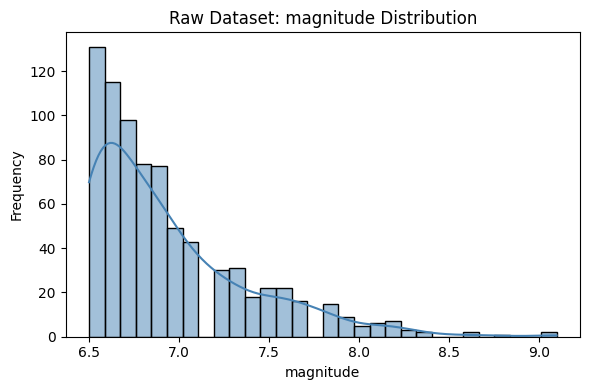

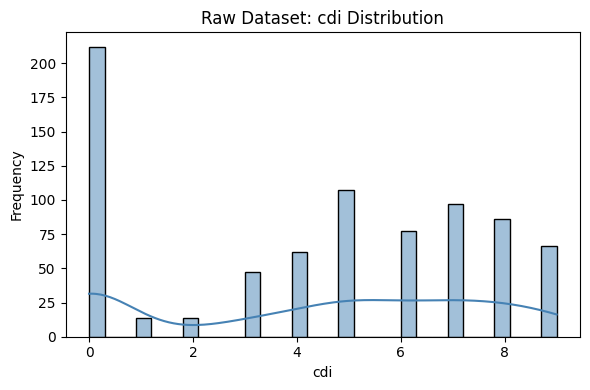

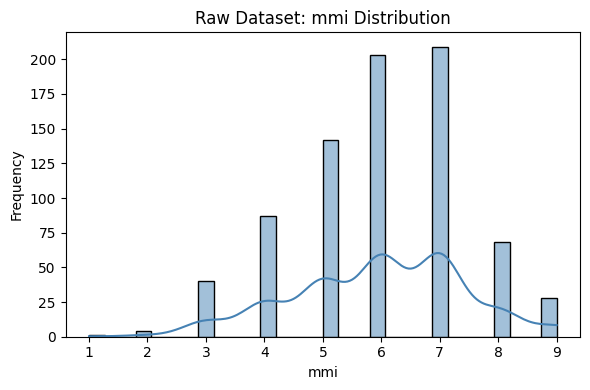

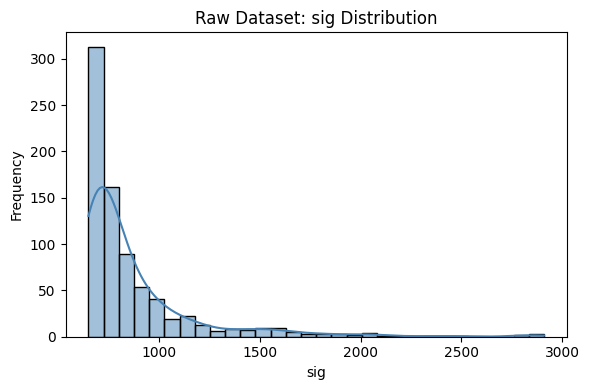

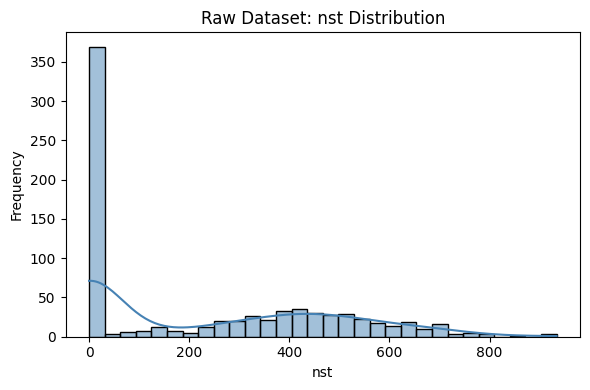

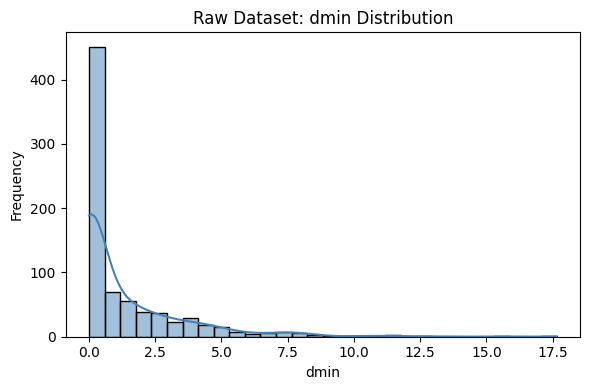

🛑 Display limit reached (6 plots).

📊 Plotting distributions for Imputed Dataset (13 numeric features)...


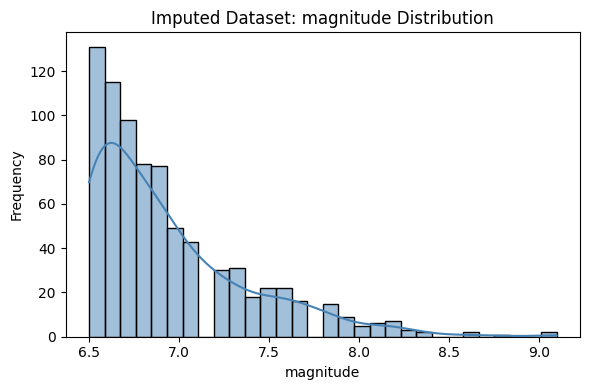

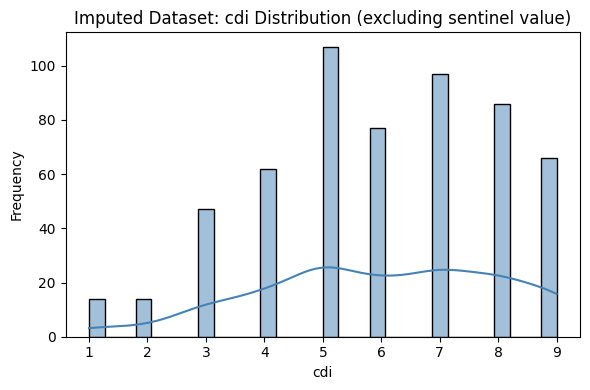

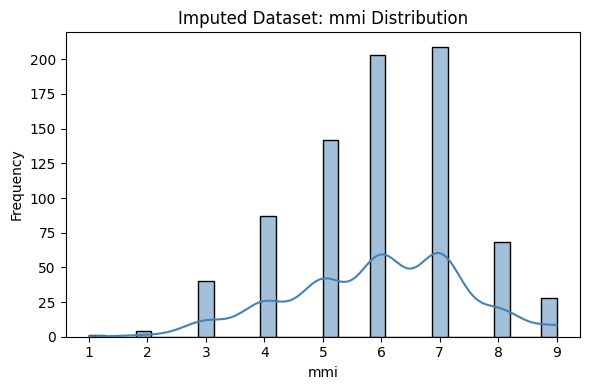

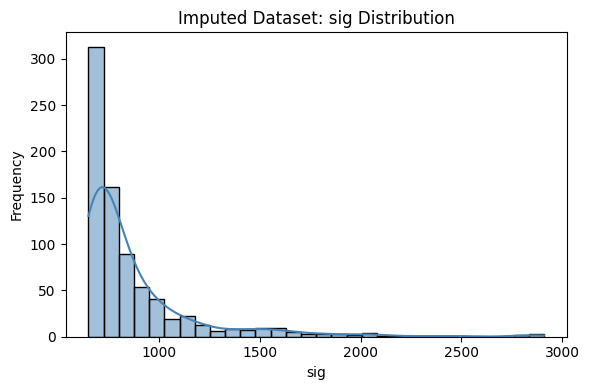

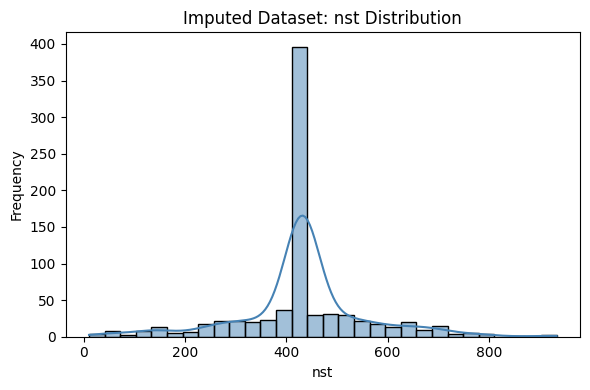

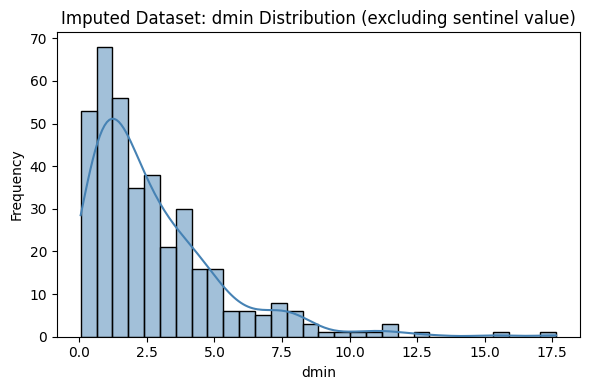

🛑 Display limit reached (6 plots).


In [4]:
def plot_feature_distributions(df, name="dataset", sentinel=-999, max_cols=6):
    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    print(f"\n📊 Plotting distributions for {name} ({len(numeric_cols)} numeric features)...")

    for i, col in enumerate(numeric_cols):
        col_data = df[col]
        filtered_data = col_data[col_data != sentinel]
        dropped_count = len(col_data) - len(filtered_data)

        # Dynamic title logic
        title_suffix = f" (excluding sentinel value)" if dropped_count > 0 else ""
        plt.figure(figsize=(6, 4))
        sns.histplot(filtered_data, kde=True, bins=30, color="steelblue")
        plt.title(f"{name}: {col} Distribution{title_suffix}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

        if i >= max_cols - 1:
            print(f"🛑 Display limit reached ({max_cols} plots).")
            break

# Plot distributions for both datasets
plot_feature_distributions(raw_df, name="Raw Dataset")
plot_feature_distributions(imputed_df, name="Imputed Dataset")

#### Distribution Findings Summary

The distribution audit revealed the following:

- Bimodality is present only in the raw dataset and is **confirmed to result from `0` values**, which are absent from the imputed dataset and excluded during feature-specific filtering
- Approximately half of the features show symmetric distributions suitable for standard scaling
- The remaining features exhibit **moderate to high skewness**, flagged for potential power ladder transformation (e.g., log, sqrt, ...)
- `dmin` and `sig` contain **extreme outliers**, which may distort correlation, binning, or scaling logic
- `magnitude` may contain a few outliers, flagged for review

No transformations were applied at this stage. Flagged features will be reviewed in Section 2.2 for scaling and transformation decisions.

[↑ Back to Contents](#contents)

## 3.4 Multicollinearity Audit

We begin feature engineering by auditing multicollinearity and preparing the feature space for interaction modeling, scaling, and transformation.

### Correlation and VIF Analysis

We assess pairwise correlations and compute Variance Inflation Factors (VIF) to identify redundant features and support pruning decisions. This ensures stability and interpretability in downstream modeling.

- A **correlation matrix** is used to visualize pairwise relationships and flag highly correlated features (|r| > 0.8)
- **Variance Inflation Factor (VIF)** is computed to quantify multicollinearity and identify features with inflated variance due to redundancy

Features flagged for high correlation or VIF will be reviewed before interaction modeling and scaling.

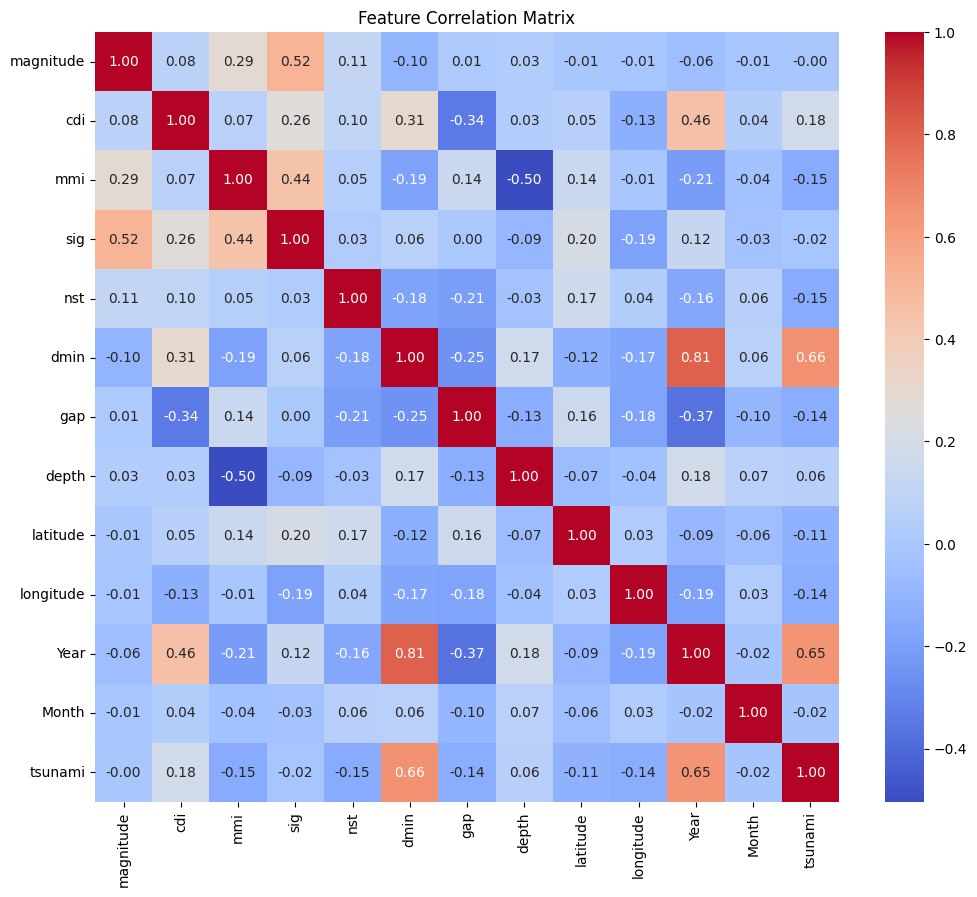

In [5]:
corr_matrix = imputed_df.select_dtypes(include='number').corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

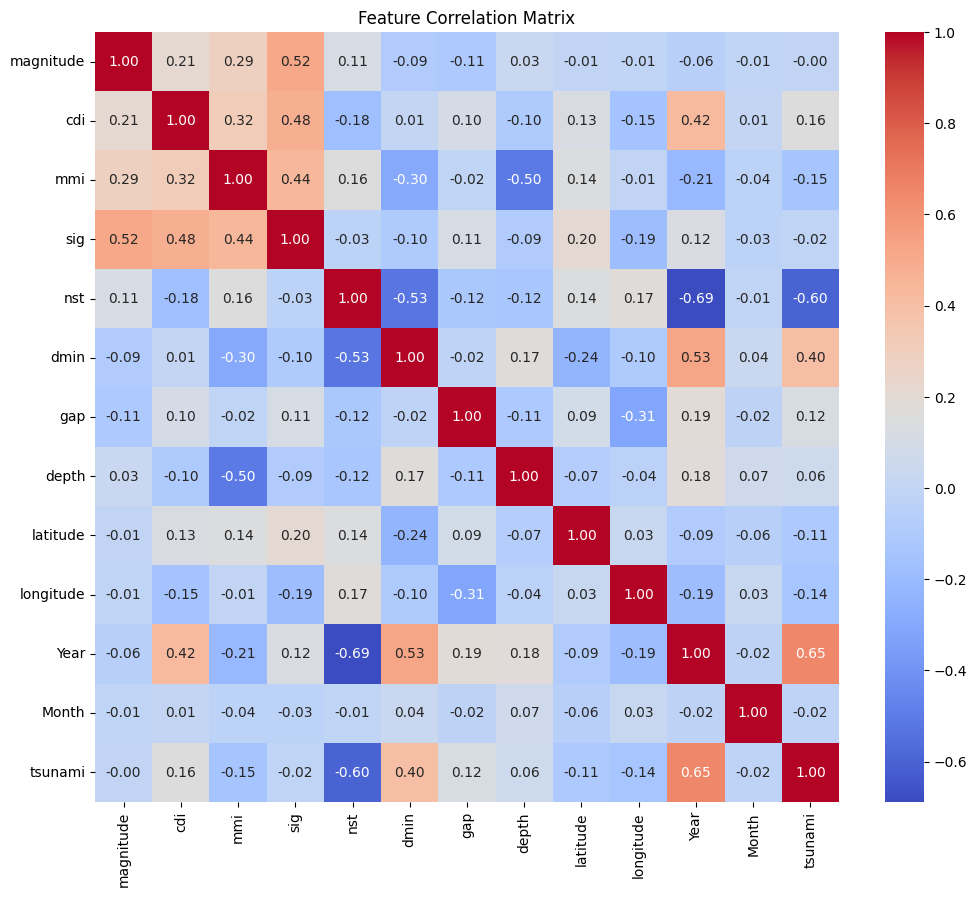

In [6]:
corr_matrix = raw_df.select_dtypes(include='number').corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

#### Correlation Audit

We assessed pairwise correlations across `raw_df` and `imputed_df`, excluding the response variable.

- `year` shows moderate to strong correlation with `cdi` (r = 0.46) and `dmin` (r = 0.81)
- `depth` and `mmi` exhibit a moderate inverse correlation (r = –0.50)
- `sig` and `magnitude` show moderate positive correlation (r = 0.52)
- `sig` and `mmi` also show moderate correlation (r = 0.44)

These relationships suggest potential redundancy or shared signal domains, especially in temporal and seismic intensity features.

In [7]:
X = add_constant(imputed_df.select_dtypes(include='number'))
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

      Feature            VIF
0       const  472752.533297
1   magnitude       1.557804
2         cdi       1.496059
3         mmi       1.860441
4         sig       1.959328
5         nst       1.224806
6        dmin       3.372078
7         gap       1.548035
8       depth       1.456448
9    latitude       1.186568
10  longitude       1.190422
11       Year       4.293144
12      Month       1.047876
13    tsunami       2.059275


In [8]:
X = add_constant(raw_df.select_dtypes(include='number'))
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

      Feature            VIF
0       const  394669.008139
1   magnitude       1.555704
2         cdi       1.865952
3         mmi       2.013233
4         sig       2.071355
5         nst       2.289048
6        dmin       1.709990
7         gap       1.236929
8       depth       1.488056
9    latitude       1.143930
10  longitude       1.185189
11       Year       3.601460
12      Month       1.017303
13    tsunami       1.988731


#### VIF Audit

We computed Variance Inflation Factors (VIF) for both `raw_df` and `imputed_df`.

- No features exceeded the critical VIF threshold of 5
- `Year` showed the highest VIF (4.03 in `imputed_df`, 3.60 in `raw_df`) but remains below exclusion threshold
- All other features showed acceptable VIF scores (mostly < 2.5), indicating manageable multicollinearity

These results support retention of all features for interaction modeling and transformation.

### Multicollinearity Conclusion

No features were excluded at this stage. Correlation and VIF audits suggest manageable multicollinearity across both datasets. Flagged relationships will be monitored during interaction modeling (2.2) and feature pruning (2.4).

[↑ Back to Contents](#contents)

## 3.5 Binning and Scaling

We probably won't be doing this.

[↑ Back to Contents](#contents)

## 3.6 Interaction Term Modeling

We generate and validate interaction terms using domain logic and hierarchical constraints.

- All 2-way combinations are considered unless flagged for multicollinearity in Section 3.4
- 3-way interactions are only included if all corresponding 2-way terms and main effects are present
- This preserves model hierarchy and interpretability

Interaction terms will be reviewed for significance and retained based on model fit and domain relevance.

Split the data to avoid leakage

In [9]:
def split_data(df: pd.DataFrame, target_col: str = "target", test_size: float = 0.2, random_state: int = 42):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

In [10]:
X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed = split_data(imputed_df, 'tsunami')
X_train_raw, X_test_raw, y_train_raw, y_test_raw = split_data(raw_df, 'tsunami')

Copilot gave me stepwise regression

In [11]:
def stepwise_selection(X, y, 
                       initial_features=[], 
                       threshold_in=0.01, 
                       verbose=True):
    """
    Perform forward stepwise selection based on p-values from statsmodels OLS.

    Parameters:
    - X: DataFrame of candidate predictors
    - y: Series or array of target variable
    - initial_features: list of features to start with
    - threshold_in: p-value threshold for including a feature
    - verbose: whether to print progress

    Returns:
    - List of selected features
    """
    included = list(initial_features)
    while True:
        changed = False
        # Candidates not yet included
        excluded = list(set(X.columns) - set(included))
        new_pvals = pd.Series(index=excluded, dtype=float)

        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            new_pvals[new_column] = model.pvalues[new_column]

        best_pval = new_pvals.min()
        if best_pval < threshold_in:
            best_feature = new_pvals.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f"Added {best_feature} with p-value {best_pval:.4f}")

        if not changed:
            break

    return included

In [12]:
selected_features = stepwise_selection(X_train_imputed, y_train_imputed)
print("Selected features:", selected_features)

Added dmin with p-value 0.0000
Added Year with p-value 0.0000
Added cdi with p-value 0.0014
Selected features: ['dmin', 'Year', 'cdi']


Considering 2-way interactions with Copilot.

In [13]:
from itertools import combinations

def add_interactions(X):
    X_new = X.copy()
    for a, b in combinations(X.columns, 2):
        X_new[f'{a}:{b}'] = X[a] * X[b]
    return X_new

In [14]:
X_train_imputed_2_way = add_interactions(X_train_imputed)

In [15]:
selected_features = stepwise_selection(X_train_imputed_2_way, y_train_imputed)
print("Selected features:", selected_features)

Added dmin with p-value 0.0000
Added dmin:Year with p-value 0.0000
Added dmin:gap with p-value 0.0000
Added sig with p-value 0.0007
Added magnitude:Year with p-value 0.0001
Added magnitude:dmin with p-value 0.0000
Added nst:depth with p-value 0.0001
Added dmin:depth with p-value 0.0028
Selected features: ['dmin', 'dmin:Year', 'dmin:gap', 'sig', 'magnitude:Year', 'magnitude:dmin', 'nst:depth', 'dmin:depth']


That didn't work. 2-way terms are selected without primitive terms which is not a valid model.

In [16]:
selected_features_imputed = stepwise_selection(X_train_imputed, y_train_imputed)
print("Selected features:", selected_features_imputed)

Added dmin with p-value 0.0000
Added Year with p-value 0.0000
Added cdi with p-value 0.0014
Selected features: ['dmin', 'Year', 'cdi']


In [17]:
selected_features_raw = stepwise_selection(X_train_raw, y_train_raw)
print("Selected features:", selected_features_raw)

Added Year with p-value 0.0000
Added nst with p-value 0.0000
Added sig with p-value 0.0060
Added magnitude with p-value 0.0005
Selected features: ['Year', 'nst', 'sig', 'magnitude']


In [18]:
X_train_imputed_reduced_2_way = add_interactions(X_train_imputed[selected_features_imputed])
X_train_raw_reduced_2_way = add_interactions(X_train_raw[selected_features_raw])

new data frame of original primitivees plus the 2 way interactions of the 3 selected features since other primitives may become important after adding interactions.

In [19]:
X_train_imputed_2_way = pd.concat([X_train_imputed, X_train_imputed_reduced_2_way.drop(columns=selected_features_imputed)], axis=1)
X_train_raw_2_way = pd.concat([X_train_raw, X_train_raw_reduced_2_way.drop(columns=selected_features_raw)], axis=1)

I pass our previously selected features `'dmin', 'Year', 'cdi'` as initial features with a dataset containing th

In [20]:
selected_features_imputed_two = stepwise_selection(X_train_imputed_2_way, y_train_imputed, selected_features_imputed)
print("Selected features:", selected_features_imputed_two)

Added dmin:Year with p-value 0.0005
Added gap with p-value 0.0031
Added sig with p-value 0.0038
Added magnitude with p-value 0.0000
Added depth with p-value 0.0021
Selected features: ['dmin', 'Year', 'cdi', 'dmin:Year', 'gap', 'sig', 'magnitude', 'depth']


In [21]:
selected_features_raw_two = stepwise_selection(X_train_raw_2_way, y_train_imputed, selected_features_raw)
print("Selected features:", selected_features_raw_two)

Added Year:magnitude with p-value 0.0020
Added depth with p-value 0.0086
Selected features: ['Year', 'nst', 'sig', 'magnitude', 'Year:magnitude', 'depth']


We have slightly different models between the raw and imputed datasets.

[↑ Back to Contents](#contents)

## 3.7 Export Transformed Dataset

This section finalizes the feature matrix for modeling and audit. It merges the original feature set with depth-2 interaction terms derived from selected primitives.

Two versions are exported:
- `earthquake_imputed_2way.csv`: imputed features + depth-2 interactions
- `earthquake_raw_2way.csv`: raw features + depth-2 interactions

Interaction terms were generated from the selected primitives only. Additional primitives added later are retained for ancestry completeness but not used in interaction scaffolding.

In [22]:
# Generate depth-2 interactions from selected primitives (imputed and raw)
imputed_df_reduced_2_way = add_interactions(imputed_df[selected_features_imputed])
raw_df_reduced_2_way = add_interactions(raw_df[selected_features_raw])

In [23]:
# Merge original DataFrames with interaction terms
# Drop selected primitives from interaction scaffold to avoid duplication
imputed_df_2_way = pd.concat([imputed_df, imputed_df_reduced_2_way.drop(columns=selected_features_imputed)], axis=1)
raw_df_2_way = pd.concat([raw_df, raw_df_reduced_2_way.drop(columns=selected_features_raw)], axis=1)

In [24]:
# Export final datasets to ../data/interaction/
# Includes all primitives (selected + added later) and depth-2 interactions
imputed_df_2_way.to_csv('../data/interaction/earthquake_imputed_2way.csv', index=False)
raw_df_2_way.to_csv('../data/interaction/earthquake_raw_2way.csv', index=False)

[↑ Back to Contents](#contents)